## Washington oil FUELING from all sources 
- Fueling counted if TransferType is "Fueling", regardless of where fueling happens 
- Total volume fueling in this analysis: 680,236,999 gallons  

### Known issues
- I need to convert to liters for our intents and purposes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# User inputs
file_dir  = '/Users/rmueller/Documents/UBC/MIDOSS/Data/DeptOfEcology/'
file_name = 'MuellerTrans4-30-20.xlsx'

In [3]:
# Import columns are: (E) 'StartDateTime, (O) Region, (P) Product, (Q) Quantity in Gallons, (R) Transfer Type (Fueling, Cargo, or Other)', (x) ReceiverTypeDescription 
df = pd.read_excel(f'{file_dir}{file_name}',sheet_name='Vessel Oil Transfer', 
                   usecols="E,O,P,Q,R,X")


### Extract data for vessel fueling operations

In [4]:
# Get all cargo fuel transfers
transfer_type = 'Fueling'
bool_cargo = df['TransferType']==f'{transfer_type}'
cargo_data = df[bool_cargo]

In [5]:
oil_traffic = {}

### Evaluate marine oil export

#### By vessel type (This is the right way though I still need to remove Vancouver, WA)

In [6]:
# create dataset of export cargo in which export cargo is defined as
# all cargo being deliverd from (land-based) marine terminal
cargo_export = cargo_data[cargo_data.TransferType.str.contains(f'{transfer_type}')]
   
# need to re-set indexing in order to use row-index as data_frame index
cargo_export.reset_index(drop=True, inplace=True)    

In [7]:
# introduce dictionary for cargo traffic
oil_traffic[f'{transfer_type}'] = {}
ship_types = ['TANK BARGE', 'TANK SHIP', 'CARGO', 'FERRY VESSEL','FISHING VESSEL', 'PASSENGER SHIP','OTHER']

for ships in ship_types:
    oil_traffic[f'{transfer_type}'][f'{ships}']                    = {}
    oil_traffic[f'{transfer_type}'][f'{ships}']['percent_volume']  = {} # percentage of total crude export by oil type 
    oil_traffic[f'{transfer_type}'][f'{ships}']['volume_total']    = 0
    oil_traffic[f'{transfer_type}'][f'{ships}']['volume']          = [] # a vector of volumes ordered to pair with oil_type
    oil_traffic[f'{transfer_type}'][f'{ships}']['oil_type']        = [] # a vector of oil types ordered to pair with volume_export

# total
oil_traffic[f'{transfer_type}']['outbound_total']                       = {}
oil_traffic[f'{transfer_type}']['outbound_total']['all']                = 0
oil_traffic[f'{transfer_type}']['outbound_total']['atb_barge_tankers']  = 0

# identify ship traffic 
[nrows,ncols] = cargo_export.shape

# total up volume of oil transferred onto ATB BARGES, non-ATB barges, and other vessels
# create counter for vessel-type
barge_counter = 0
cargo_counter = 0
tanker_counter = 0
ferry_counter = 0
fishing_counter = 0
passenger_counter = 0
other_counter = 0

for rows in range(nrows):
            
    # Add up all oil import to refineries and terminals, regardless of vessel-type
    oil_traffic[f'{transfer_type}']['outbound_total']['all'] += cargo_export.TransferQtyInGallon[rows]
    
    # ATBs and tank barges
    if 'TANK BARGE' in cargo_export.ReceiverTypeDescription[rows]: 
        oil_traffic[f'{transfer_type}']['TANK BARGE']['volume_total'] += cargo_export.TransferQtyInGallon[rows]
        oil_traffic[f'{transfer_type}']['TANK BARGE']['volume'].append(cargo_export.TransferQtyInGallon[rows])
        oil_traffic[f'{transfer_type}']['TANK BARGE']['oil_type'] .append(cargo_export.Product[rows])
        barge_counter += 1
    
    # Tankers
    elif 'TANK SHIP' in cargo_export.ReceiverTypeDescription[rows]: 
        oil_traffic[f'{transfer_type}']['TANK SHIP']['volume_total'] += cargo_export.TransferQtyInGallon[rows] 
        oil_traffic[f'{transfer_type}']['TANK SHIP']['volume'].append(cargo_export.TransferQtyInGallon[rows])
        oil_traffic[f'{transfer_type}']['TANK SHIP']['oil_type'].append(cargo_export.Product[rows])
        tanker_counter += 1 
        
    # Cargo
    elif ('CONTAINER SHIP'   in cargo_export.ReceiverTypeDescription[rows] or \
        'BULK CARRIER'       in cargo_export.ReceiverTypeDescription[rows] or \
        'PURE CAR CARRIER'   in cargo_export.ReceiverTypeDescription[rows] or \
        'GENERAL CARGO SHIP' in cargo_export.ReceiverTypeDescription[rows]): 
        oil_traffic[f'{transfer_type}']['CARGO']['volume_total'] += cargo_export.TransferQtyInGallon[rows] 
        oil_traffic[f'{transfer_type}']['CARGO']['volume'].append(cargo_export.TransferQtyInGallon[rows])
        oil_traffic[f'{transfer_type}']['CARGO']['oil_type'].append(cargo_export.Product[rows])
        cargo_counter += 1
     
   # Ferries
    elif ('FERRY VESSEL' in cargo_export.ReceiverTypeDescription[rows]): 
        oil_traffic[f'{transfer_type}']['FERRY VESSEL']['volume_total'] += cargo_export.TransferQtyInGallon[rows] 
        oil_traffic[f'{transfer_type}']['FERRY VESSEL']['volume'].append(cargo_export.TransferQtyInGallon[rows])
        oil_traffic[f'{transfer_type}']['FERRY VESSEL']['oil_type'].append(cargo_export.Product[rows])
        ferry_counter += 1
     
    # Fishing
    elif ('FISHING VESSEL' in cargo_export.ReceiverTypeDescription[rows]): 
        oil_traffic[f'{transfer_type}']['FISHING VESSEL']['volume_total'] += cargo_export.TransferQtyInGallon[rows] 
        oil_traffic[f'{transfer_type}']['FISHING VESSEL']['volume'].append(cargo_export.TransferQtyInGallon[rows])
        oil_traffic[f'{transfer_type}']['FISHING VESSEL']['oil_type'].append(cargo_export.Product[rows])
        ferry_counter += 1
        
    # Passenger
    elif ('FERRY VESSEL' in cargo_export.ReceiverTypeDescription[rows]): 
        oil_traffic[f'{transfer_type}']['PASSENGER SHIP']['volume_total'] += cargo_export.TransferQtyInGallon[rows] 
        oil_traffic[f'{transfer_type}']['PASSENGER SHIP']['volume'].append(cargo_export.TransferQtyInGallon[rows])
        oil_traffic[f'{transfer_type}']['PASSENGER SHIP']['oil_type'].append(cargo_export.Product[rows])
        ferry_counter += 1
              
    # Other
    else:    
        oil_traffic[f'{transfer_type}']['OTHER']['volume_total'] += cargo_export.TransferQtyInGallon[rows] 
        oil_traffic[f'{transfer_type}']['OTHER']['volume'].append(cargo_export.TransferQtyInGallon[rows])
        oil_traffic[f'{transfer_type}']['OTHER']['oil_type'].append(cargo_export.Product[rows])
        other_counter += 1
        
print('Total outbound fueling in this analysis: ' + str(oil_traffic[f'{transfer_type}']['outbound_total']['all']) + ' gallons')

Total outbound fueling in this analysis: 680236999 gallons


In [8]:
# Calculate percent of total transport by vessel type
barge_percent       = 100*oil_traffic[f'{transfer_type}']['TANK BARGE']['volume_total']/oil_traffic[f'{transfer_type}']['outbound_total']['all']
tanker_percent    = 100*oil_traffic[f'{transfer_type}']['TANK SHIP']['volume_total']/oil_traffic[f'{transfer_type}']['outbound_total']['all']
cargo_percent     = 100*oil_traffic[f'{transfer_type}']['CARGO']['volume_total']/oil_traffic[f'{transfer_type}']['outbound_total']['all']
ferry_percent     = 100*oil_traffic[f'{transfer_type}']['FERRY VESSEL']['volume_total']/oil_traffic[f'{transfer_type}']['outbound_total']['all']
fishing_percent   = 100*oil_traffic[f'{transfer_type}']['FISHING VESSEL']['volume_total']/oil_traffic[f'{transfer_type}']['outbound_total']['all']
passenger_percent = 100*oil_traffic[f'{transfer_type}']['PASSENGER SHIP']['volume_total']/oil_traffic[f'{transfer_type}']['outbound_total']['all']
other_percent     = 100*oil_traffic[f'{transfer_type}']['OTHER']['volume_total']/oil_traffic[f'{transfer_type}']['outbound_total']['all']

print('barges: ' + str(barge_percent) + '%')
print('tanker: ' + str(tanker_percent) + '%')
print('cargo: '  + str(cargo_percent) + '%')
print('ferry: '  + str(ferry_percent) + '%')
print('fishing: ' + str(fishing_percent) + '%')
print('passenger: ' + str(passenger_percent) + '%')
print('other: ' + str(other_percent) + '%')


barges: 1.52030175001%
tanker: 7.82007419152%
cargo: 62.2887081448%
ferry: 2.62021251802%
fishing: 1.60338455803%
passenger: 0.0%
other: 24.1473188376%


Text(0.5,1,'Types of vessels by volume receiving fueling from land-based platform identified as terminal or refinery')

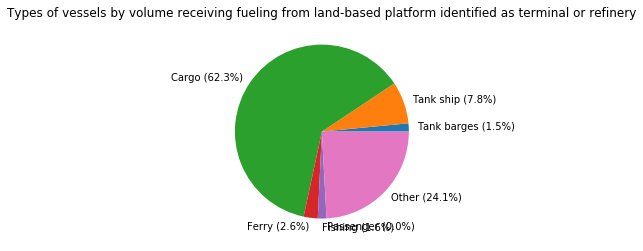

In [9]:
volume_fuelingout_byvessel = [oil_traffic[f'{transfer_type}']['TANK BARGE']['volume_total'], 
                             oil_traffic[f'{transfer_type}']['TANK SHIP']['volume_total'],
                             oil_traffic[f'{transfer_type}']['CARGO']['volume_total'],
                             oil_traffic[f'{transfer_type}']['FERRY VESSEL']['volume_total'],
                             oil_traffic[f'{transfer_type}']['FISHING VESSEL']['volume_total'],
                             oil_traffic[f'{transfer_type}']['PASSENGER SHIP']['volume_total'],
                             oil_traffic[f'{transfer_type}']['OTHER']['volume_total']]
labels = [f'Tank barges ({barge_percent:3.1f}%)', f'Tank ship ({tanker_percent:3.1f}%)',f'Cargo ({cargo_percent:3.1f}%)', 
         f'Ferry ({ferry_percent:3.1f}%)', f'Fishing ({fishing_percent:3.1f}%)', f'Passenger ({passenger_percent:3.1f}%)',
         f'Other ({other_percent:3.1f}%)']
plt.gca().axis("equal")
plt.pie(volume_fuelingout_byvessel, labels= labels)
plt.title('Types of vessels by volume receiving fueling from land-based platform identified as terminal or refinery')

#### By oil type within vessel type classification

In [10]:
ship_types = ['TANK BARGE', 'TANK SHIP', 'CARGO', 'FERRY VESSEL','FISHING VESSEL', 'PASSENGER SHIP','OTHER']

for ships in ship_types:
    oil_traffic[f'{transfer_type}'][f'{ships}']['GASOLINE']=0
    oil_traffic[f'{transfer_type}'][f'{ships}']['DIESEL/MARINE GAS OIL']=0
    oil_traffic[f'{transfer_type}'][f'{ships}']['DIESEL LOW SULPHUR (ULSD)']=0
    oil_traffic[f'{transfer_type}'][f'{ships}']['BUNKER OIL/HFO']=0
    oil_traffic[f'{transfer_type}'][f'{ships}']['other']=0


oil_types = ['GASOLINE', 'DIESEL/MARINE GAS OIL', 
             'DIESEL LOW SULPHUR (ULSD)', 'BUNKER OIL/HFO', 'other']

percent_check = 0
for oil_name in range(len(oil_types)):   
    for ships in ship_types:
        for rows in range(len(oil_traffic[f'{transfer_type}'][f'{ships}']['volume'])):  
            if oil_types[oil_name] in oil_traffic[f'{transfer_type}'][f'{ships}']['oil_type'][rows]: 
                oil_traffic[f'{transfer_type}'][f'{ships}'][oil_types[oil_name]] += oil_traffic[f'{transfer_type}'][f'{ships}']['volume'][rows]

                
        oil_traffic[f'{transfer_type}'][f'{ships}']['percent_volume'][oil_types[oil_name]]    = 100 * oil_traffic[f'{transfer_type}'][f'{ships}'][oil_types[oil_name]]/oil_traffic[f'{transfer_type}']['outbound_total']['all']

     

In [11]:
oil_traffic['Fueling']['TANK BARGE']['percent_volume']

{'GASOLINE': 0.0,
 'DIESEL/MARINE GAS OIL': 0.34689850794193566,
 'DIESEL LOW SULPHUR (ULSD)': 0.16655959638561207,
 'BUNKER OIL/HFO': 0.92349034369416882,
 'other': 0.0}

In [12]:
labels

['Tank barges (1.5%)',
 'Tank ship (7.8%)',
 'Cargo (62.3%)',
 'Ferry (2.6%)',
 'Fishing (1.6%)',
 'Passenger (0.0%)',
 'Other (24.1%)']

#### Plot up ATB fuel types

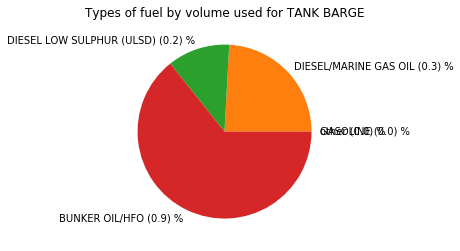

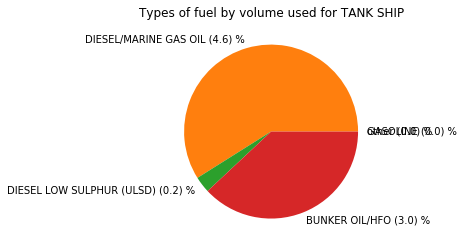

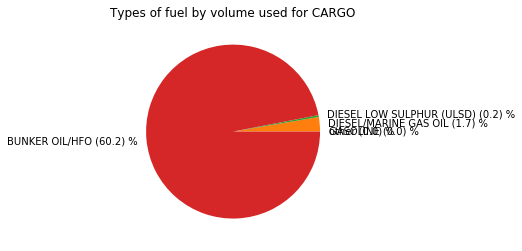

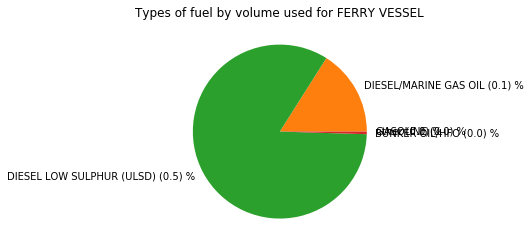

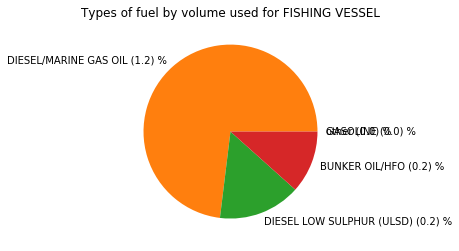

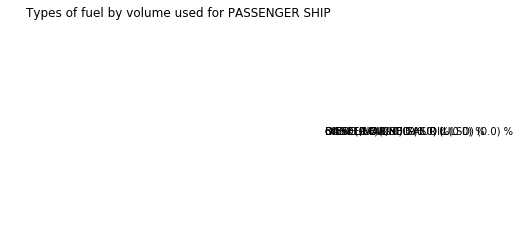

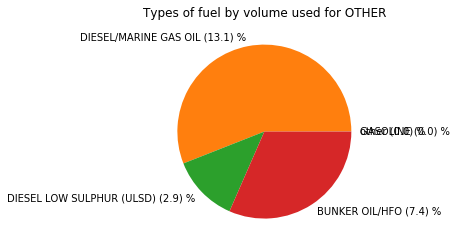

In [13]:
ship_types = ['TANK BARGE', 'TANK SHIP', 'CARGO', 'FERRY VESSEL','FISHING VESSEL', 'PASSENGER SHIP','OTHER']

for ships in ship_types:
    plot_volume = []
    for ii in range(len(oil_types)):
         plot_volume.append(oil_traffic[f'{transfer_type}'][f'{ships}'][oil_types[ii]])

    labels = []
    for ii in range(len(oil_types)):
        #print(f'{oil_traffic[f"{transfer_type}"]["TANK BARGE"]["percent_volume"][oil_types[ii]]:3.1f}')
        labels.append(f'{oil_types[ii]} ({oil_traffic[f"{transfer_type}"][f"{ships}"]["percent_volume"][oil_types[ii]]:3.1f}) %')
    
    plt.figure()
    plt.gca().axis("equal")
    plt.pie(plot_volume, labels= labels)
    plt.title('Types of fuel by volume used for ' + f'{ships}')

### Add up volume transferred by fuel type 

In [15]:
# Add up the total volume of marine transport by product (this includes all transfers)
gas_export_data    = cargo_data[cargo_data['Product']=='GASOLINE']
gas_export_total   = gas_export_data['TransferQtyInGallon'].sum()
gas_export_percent = 100*gas_export_total/cargo_data.TransferQtyInGallon.sum()

diesel_export_data    = cargo_data[cargo_data['Product']=='DIESEL/MARINE GAS OIL']
diesel_export_total   = diesel_export_data['TransferQtyInGallon'].sum()
diesel_export_percent = 100*diesel_export_total/cargo_data.TransferQtyInGallon.sum()

bunker_export_data  = cargo_data[cargo_data['Product']=='BUNKER OIL/HFO']
bunker_export_total = bunker_export_data['TransferQtyInGallon'].sum()
bunker_export_percent = 100*bunker_export_total/cargo_data.TransferQtyInGallon.sum()

jet_export_data   = cargo_data[cargo_data['Product']=='JET FUEL/KEROSENE']
jet_export_total  = jet_export_data['TransferQtyInGallon'].sum()
jet_export_percent = 100*jet_export_total/cargo_data.TransferQtyInGallon.sum()

ulsd_export_data  = cargo_data[cargo_data['Product']=='DIESEL LOW SULPHUR (ULSD)']
ulsd_export_total = ulsd_export_data['TransferQtyInGallon'].sum()
ulsd_export_percent = 100*ulsd_export_total/cargo_data.TransferQtyInGallon.sum()


crude_export_data  = cargo_data[cargo_data['Product'].str.contains('CRUDE')]
crude_export_total = crude_export_data['TransferQtyInGallon'].sum()
crude_export_percent = 100*crude_export_total/cargo_data.TransferQtyInGallon.sum()

Other_fuel_total = cargo_data['TransferQtyInGallon'].sum() - crude_export_total - ulsd_export_total - jet_export_total - bunker_export_total - diesel_export_total - gas_export_total 
other_fuel_percent = 100*Other_fuel_total/cargo_data.TransferQtyInGallon.sum()

total_percent = other_fuel_percent+crude_export_percent+ulsd_export_percent+jet_export_percent+bunker_export_percent+diesel_export_percent+gas_export_percent
total_percent

100.0

### Plot up results

Text(0.5,1,'Marine fuel transfers by oil type')

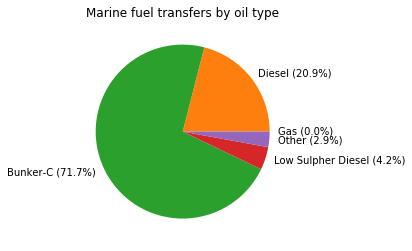

In [20]:
oil_export_values = [gas_export_total, diesel_export_total , bunker_export_total, ulsd_export_total, Other_fuel_total]
#colors = ['b', 'g', 'r', 'c', 'm', 'y']
labels = [f'Gas ( f'Diesel ({diesel_export_percent:3.1f}%)', f'Bunker-C ({bunker_export_percent:3.1f}%)', f'Low Sulpher Diesel ({ulsd_export_percent:3.1f}%)', f'Other ({other_fuel_percent:3.1f}%)']
plt.gca().axis("equal")
plt.pie(oil_export_values, labels= labels)
plt.title('Marine fuel transfers by oil type')

In [17]:
cargo_data

,StartDateTime,Region,Product,TransferQtyInGallon,TransferType,ReceiverTypeDescription
0,2018-01-01 06:15:00,KING,DIESEL/MARINE GAS OIL,2500,Fueling,PASSENGER SHIP
10,2018-01-02 08:55:00,KING,BIODIESEL,1200,Fueling,Un-regulated Vessel
11,2018-01-01 13:30:00,KING,BIODIESEL,9000,Fueling,FERRY VESSEL
12,2018-01-01 23:00:00,SKAGIT,BIODIESEL,9000,Fueling,FERRY VESSEL
13,2018-01-01 19:30:00,KING,BIODIESEL,9000,Fueling,FERRY VESSEL
14,2018-01-01 23:30:00,KITSAP,BIODIESEL,18000,Fueling,FERRY VESSEL
15,2018-01-02 13:30:00,KING,BIODIESEL,9000,Fueling,FERRY VESSEL
16,2018-01-02 20:45:00,SAN JUAN,BIODIESEL,9000,Fueling,FERRY VESSEL
17,2018-01-02 21:30:00,ISLAND,BIODIESEL,9000,Fueling,FERRY VESSEL
18,2018-01-02 21:40:00,KITSAP,BIODIESEL,18000,Fueling,FERRY VESSEL
